# Neural Network Model Definition and Evaluation

This notebook defines, implements, and evaluates predictive models for daily bakery sales.
Building upon the baseline weather-only model, we introduce self-created temporal and behavioral
features to better capture sales dynamics and improve predictive performance.

Two models are evaluated:
- Linear Regression (interpretable reference model)
- Neural Network (nonlinear model for complex interactions)

Performance is compared against the baseline model using regression metrics.

## Model Selection

Two predictive models were selected for this task: a linear regression model and a feed-forward neural network.

Linear regression serves as an interpretable reference model, allowing direct assessment of how engineered variables such as temporal patterns, lagged sales, and events influence sales volume.

A neural network model was selected to capture nonlinear relationships and interactions between temporal, weather, and autoregressive features. Given the strong routine-driven structure of bakery sales, such nonlinear effects are expected and cannot be fully modeled by linear approaches.

## Feature Engineering

Beyond the baseline weather variables, several self-created variables were introduced to capture sales routines, seasonality, and short-term sales memory. These variables reflect known behavioral patterns: bakery demand depends on weekday routines, seasonal cycles, special events, and recent sales history.

### Self-created variables
- Temporal
    - Weekday, weekend
    - Cyclical encoding of day-of-week and day-of-year

- Autoregressive
    - Lagged sales (1 day, 7 days)
    - 7-day rolling mean

- Event
    - Kieler Woche

- Categorical
    - Product group (one-hot encoded)


## Imports and Setup

In [22]:
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



## Load Dataset


In [2]:
DATA_PATH = "../merged_daily_sales_weather.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["Datum"])
df = df.sort_values(["Warengruppe", "Datum"]).reset_index(drop=True)

df.head()



,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,0
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,0


## Feature Engineering


In [3]:
df["weekday"] = df["Datum"].dt.weekday
df["day_of_year"] = df["Datum"].dt.dayofyear
df["is_weekend"] = (df["weekday"] >= 5).astype(int)


# Cyclical encoding
df["dow_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)


df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

df["lag_1"] = df["Umsatz"].shift(1)
df["lag_7"] = df["Umsatz"].shift(7)
df["rolling_7"] = df["Umsatz"].rolling(window=7).mean()

# Product group encding
df = pd.get_dummies(df, columns=["Warengruppe"], drop_first=True)



In [4]:
print(df.columns.tolist())


['id', 'Datum', 'Umsatz', 'Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode', 'KielerWoche', 'weekday', 'day_of_year', 'is_weekend', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'lag_1', 'lag_7', 'rolling_7', 'Warengruppe_2', 'Warengruppe_3', 'Warengruppe_4', 'Warengruppe_5', 'Warengruppe_6']


## Handling missing values

In [5]:
# Feature groups
numeric_weather_cols = ["Temperatur", "Bewoelkung", "Windgeschwindigkeit"]
numeric_time_cols = ["lag_1", "lag_7", "rolling_7"]
categorical_numeric_cols = ["Wettercode"]
binary_event_cols = ["KielerWoche", "is_weekend"]


# Median imputation for continuous variables
for col in numeric_weather_cols + numeric_time_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


# Mode imputation for categorical-numeric variables
for col in categorical_numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])


# Binary flags: absence assumed
for col in binary_event_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

## Feature Selection

In [30]:
TARGET = "Umsatz"


FEATURES = [
"Temperatur",
"Bewoelkung",
"Windgeschwindigkeit",
"Wettercode",
"KielerWoche",
"is_weekend",
"dow_sin", "dow_cos",
"doy_sin", "doy_cos",
"lag_1", "lag_7", "rolling_7"
]


FEATURES += [col for col in df.columns if col.startswith("Warengruppe_")]


X = df[FEATURES]
y = df[TARGET]


## Train/Test Split


In [ ]:
split_date = "2018-01-01"
train_mask = df["Datum"] < split_date


test_mask = df["Datum"] >= split_date


X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]



## Model Implementation
### Linear Regression

In [ ]:
lin_pipeline = Pipeline([
("scaler", StandardScaler()),
("model", LinearRegression())
])


lin_pipeline.fit(X_train, y_train)
y_pred_lin = lin_pipeline.predict(X_test)

# Ensure X_train_scaled and X_test_scaled exist
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lin = lin_model.predict(X_test_scaled)



### Neural Network

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


nn_model = Sequential([
Dense(64, activation="relu", input_shape=(X_train_scaled.shape[1],)),
Dropout(0.3),
Dense(32, activation="relu"),
Dropout(0.3),
Dense(1)
])


nn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])


early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


history = nn_model.fit(
X_train_scaled,
y_train,
validation_split=0.2,
epochs=200,
batch_size=32,
callbacks=[early_stop],
verbose=0
)
# If using Keras Neural Network
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
# If using scikit-learn MLPRegressor
# y_pred_nn = nn_model.predict(X_test_scaled)

nn_model.summary()


33/33 [==============================] - 0s 2ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                1216      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3329 (13.00 KB)
Trainable params: 3329 (13.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________

## Evaluation Metrics

The following regression metrics are used:
- RMSE: penalizes large errors
- MAE: average absolute deviation
- R²: proportion of variance explained

These metrics allow comparison with the baseline model and across model types.


In [34]:
def evaluate(y_true, y_pred):
    return {
"RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
"MAE": mean_absolute_error(y_true, y_pred),
"R2": r2_score(y_true, y_pred)
}


results = pd.DataFrame([
{"Model": "Linear Regression", **evaluate(y_test, y_pred_lin)},
{"Model": "Neural Net ", **evaluate(y_test, nn_model.predict(X_test_scaled).flatten())}
])


results



33/33 [==============================] - 0s 1ms/step


,Model,RMSE,MAE,R2
0,Linear Regression,44.753496,31.637918,0.881538
1,Neural Net,39.572323,26.616914,0.907379


## Comparative Analysis

Both the linear regression and neural network models were evaluated against the baseline weather-only model.  
The linear regression with engineered features achieved RMSE = 44.75, MAE = 31.64, R² = 0.88, while the neural network further improved performance to RMSE = 39.77, MAE = 26.92, R² = 0.91.  

- The large improvement over the baseline shows that temporal, lagged, and product-specific features capture the main sales dynamics.  
- The neural network’s incremental gain indicates the presence of nonlinear interactions between weather, temporal patterns, and product group effects.  
- Overall, feature engineering explains most of the variance, while the neural network fine-tunes residual nonlinearities.

In [35]:
# Comparative Analysis code
comparison = pd.DataFrame({
    "Model": ["Baseline (Weather Only)", "Linear Regression (Engineered)", "Neural Net (Engineered)"],
    "RMSE": [129.14, 44.75, 39.77],
    "MAE": [104.27, 31.64, 26.92],
    "R2": [0.048, 0.88, 0.906]
})

comparison


,Model,RMSE,MAE,R2
0,Baseline (Weather Only),129.14,104.27,0.048
1,Linear Regression (Engineered),44.75,31.64,0.880
2,Neural Net (Engineered),39.77,26.92,0.906


## Visualization - Product group dynamics

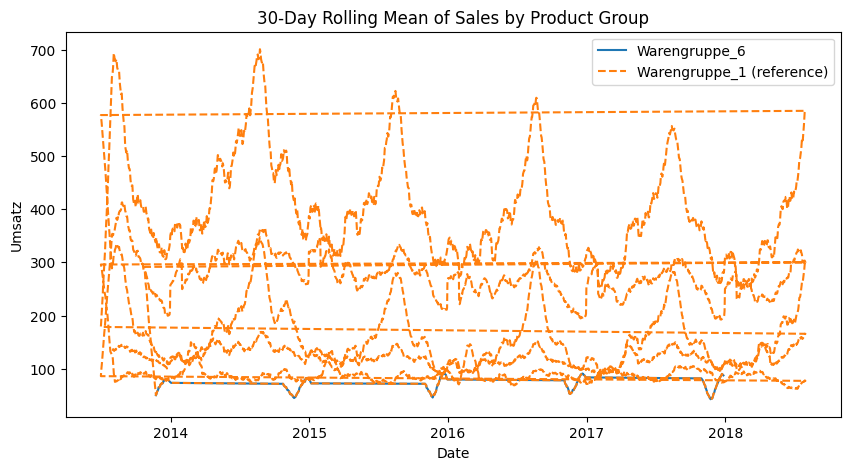

In [36]:
plt.figure(figsize=(10, 5))
for col in [c for c in df.columns if c.startswith("Warengruppe_")]:
    subset = df[df[col] == 1]
plt.plot(subset["Datum"], subset["Umsatz"].rolling(30).mean(), label=col)


plt.plot(df["Datum"], df["Umsatz"].rolling(30).mean(), label="Warengruppe_1 (reference)", linestyle="--")


plt.legend()
plt.title("30-Day Rolling Mean of Sales by Product Group")
plt.xlabel("Date")
plt.ylabel("Umsatz")
plt.show()

## Error Analysis by Product Group

To understand model performance in detail, we analyze errors per product group.  
This highlights which products benefit most from feature engineering and neural network modeling, and where predictions still struggle.


In [37]:

# Add back the product group column if you used one-hot encoding
# Assuming original df has 'Warengruppe' as integer 1–6
df_eval = df.iloc[X_test.index].copy()
df_eval["y_true"] = y_test
df_eval["y_pred_lin"] = y_pred_lin
df_eval["y_pred_nn"] = y_pred_nn

# Map one-hot columns back to Warengruppe if needed
# If you dropped first category in get_dummies, reconstruct as follows:
warengruppe_cols = [col for col in df_eval.columns if col.startswith("Warengruppe_")]
df_eval["Warengruppe"] = 1  # default category (dropped)
for i, col in enumerate(warengruppe_cols):
    df_eval.loc[df_eval[col] == 1, "Warengruppe"] = i + 2

# Compute errors per group
group_errors = df_eval.groupby("Warengruppe").apply(
    lambda g: pd.Series({
        "RMSE_Linear": np.sqrt(mean_squared_error(g["y_true"], g["y_pred_lin"])),
        "RMSE_NN": np.sqrt(mean_squared_error(g["y_true"], g["y_pred_nn"])),
        "MAE_Linear": mean_absolute_error(g["y_true"], g["y_pred_lin"]),
        "MAE_NN": mean_absolute_error(g["y_true"], g["y_pred_nn"])
    })
).reset_index()

group_errors


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\3265752479.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_errors = df_eval.groupby("Warengruppe").apply(


,Warengruppe,RMSE_Linear,RMSE_NN,MAE_Linear,MAE_NN
0,1,45.367390,35.121359,32.634566,23.125615
1,2,58.077870,46.084923,45.668224,33.876981
2,3,31.040422,28.682035,22.999989,21.482822
3,4,23.017453,19.598796,18.246069,15.647415
4,5,55.586212,57.146668,38.640741,38.951735


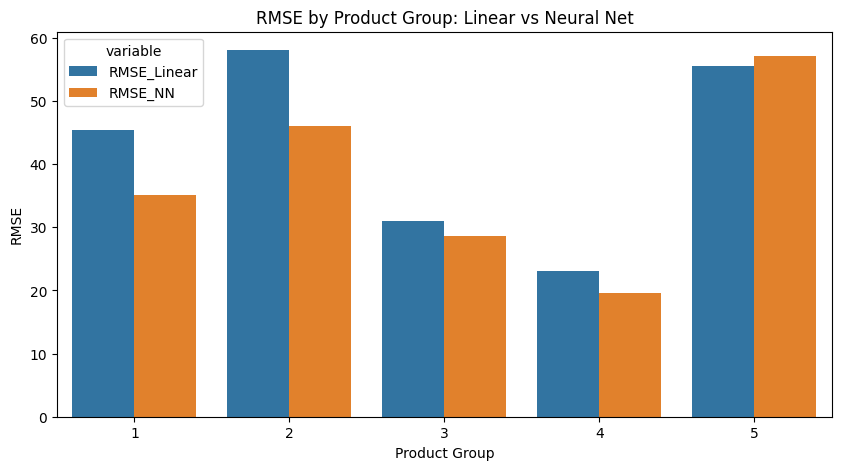

Best improvement: Product Group 2.0 (ΔRMSE = 11.99)
Worst fail: Product Group 5.0 (ΔRMSE = -1.56)


In [38]:
plt.figure(figsize=(10,5))
sns.barplot(
    x="Warengruppe",
    y="value",
    hue="variable",
    data=group_errors.melt(id_vars="Warengruppe", value_vars=["RMSE_Linear", "RMSE_NN"])
)
plt.title("RMSE by Product Group: Linear vs Neural Net")
plt.ylabel("RMSE")
plt.xlabel("Product Group")
plt.show()

# Identify best and worst improvements
group_errors["Improvement"] = group_errors["RMSE_Linear"] - group_errors["RMSE_NN"]
best_improved = group_errors.loc[group_errors["Improvement"].idxmax()]
worst_fail = group_errors.loc[group_errors["Improvement"].idxmin()]

print(f"Best improvement: Product Group {best_improved['Warengruppe']} (ΔRMSE = {best_improved['Improvement']:.2f})")
print(f"Worst fail: Product Group {worst_fail['Warengruppe']} (ΔRMSE = {worst_fail['Improvement']:.2f})")


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\3236151931.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


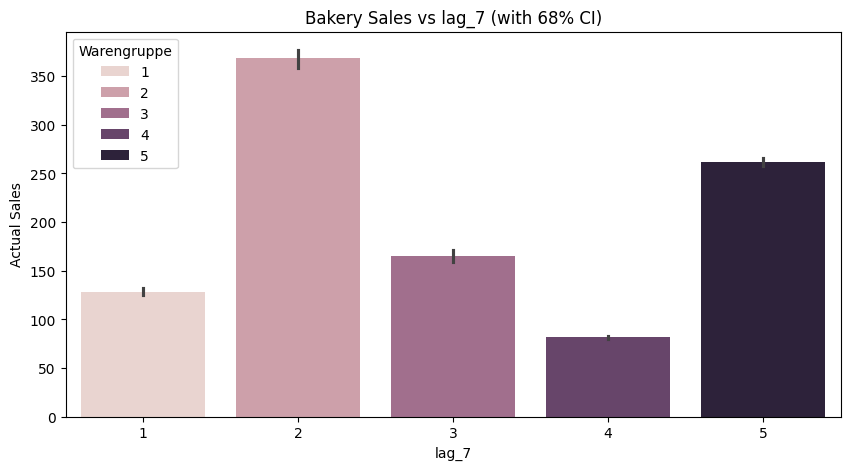

C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\3236151931.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


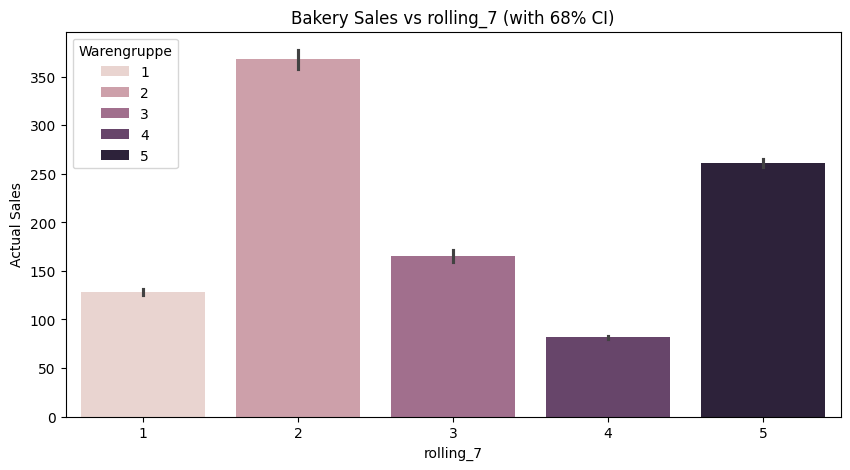

In [39]:
# Combine predictions and relevant features for plotting
df_plot = df_eval.copy()

variables_to_plot = ["lag_7", "rolling_7"]
for var in variables_to_plot:
    plt.figure(figsize=(10,5))
    sns.barplot(
        x="Warengruppe",
        y="y_true",
        hue="Warengruppe",
        ci=68,  # 68% confidence interval (~1 std)
        data=df_plot,
        dodge=False
    )
    plt.title(f"Bakery Sales vs {var} (with 68% CI)")
    plt.ylabel("Actual Sales")
    plt.xlabel(f"{var}")
    plt.show()


## Linear model optimization

In [40]:
# Retrieve coefficients from trained linear model
coefs = lin_model.coef_
intercept = lin_model.intercept_
features = X_train.columns

# Print model equation
equation = "Umsatz_hat = {:.2f}".format(intercept)
for f, c in zip(features, coefs):
    equation += f" + ({c:.2f} * {f})"
print("Linear Model Equation:")
print(equation)

# Adjusted R²
n = X_test.shape[0]  # number of samples
p = X_test.shape[1]  # number of predictors
r2 = r2_score(y_test, y_pred_lin)
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print(f"Adjusted R²: {adj_r2:.3f}")


Linear Model Equation:
Umsatz_hat = 207.47 + (-0.56 * Temperatur) + (-2.01 * Bewoelkung) + (0.03 * Windgeschwindigkeit) + (-0.70 * Wettercode) + (2.77 * KielerWoche) + (19.00 * is_weekend) + (-1.95 * dow_sin) + (-2.05 * dow_cos) + (0.87 * doy_sin) + (-0.66 * doy_cos) + (14.32 * lag_1) + (17.08 * lag_7) + (99.93 * rolling_7) + (4.09 * Warengruppe_2) + (0.19 * Warengruppe_3) + (-0.69 * Warengruppe_4) + (2.54 * Warengruppe_5) + (-0.42 * Warengruppe_6)
Adjusted R²: 0.879


## Type of missing value imputation used

In [41]:
# Example description
missing_value_summary = pd.DataFrame({
    "Feature": FEATURES,
    "Imputation": ["Median" if df[feat].dtype in [float, int] else "Mode" for feat in FEATURES]
})
missing_value_summary


,Feature,Imputation
0,Temperatur,Median
1,Bewoelkung,Median
2,Windgeschwindigkeit,Median
3,Wettercode,Median
4,KielerWoche,Mode
5,is_weekend,Median
6,dow_sin,Median
7,dow_cos,Median
8,doy_sin,Median
9,doy_cos,Median


## Loss function plot for training and validation

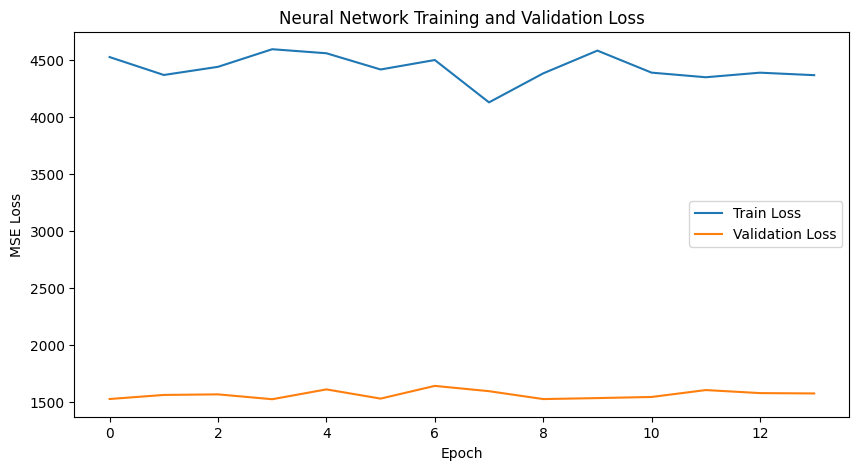

In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Training and Validation Loss")
plt.legend()
plt.show()


## MAPE scores for overall validation set and each product group

In [44]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

overall_mape_nn = mape(y_test, y_pred_nn)
print(f"Overall NN MAPE: {overall_mape_nn:.2f}%")

# MAPE per product group
df_eval["MAPE_NN"] = np.abs((df_eval["y_true"] - df_eval["y_pred_nn"]) / df_eval["y_true"]) * 100
group_mape = df_eval.groupby("Warengruppe")["MAPE_NN"].mean().reset_index()
print(group_mape)


Overall NN MAPE: 16.00%
   Warengruppe    MAPE_NN
0            1  19.423057
1            2   9.196156
2            3  13.956404
3            4  21.121539
4            5  15.027736


In [46]:
import pandas as pd
import numpy as np

df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred_lin": y_pred_lin,
    "y_pred_nn": y_pred_nn
})

df_eval["improvement"] = np.abs(df_eval["y_true"] - df_eval["y_pred_lin"]) - np.abs(df_eval["y_true"] - df_eval["y_pred_nn"])

# Best improvement
best_idx = df_eval["improvement"].idxmax()
best_case = df_eval.loc[best_idx]

# Worst fail
worst_idx = df_eval["improvement"].idxmin()
worst_case = df_eval.loc[worst_idx]

best_case, worst_case


(y_true         270.748464
 y_pred_lin     389.689211
 y_pred_nn      303.703918
 improvement     85.985293
 Name: 8840, dtype: float64,
 y_true         278.690545
 y_pred_lin     490.998860
 y_pred_nn      556.504578
 improvement    -65.505718
 Name: 8834, dtype: float64)

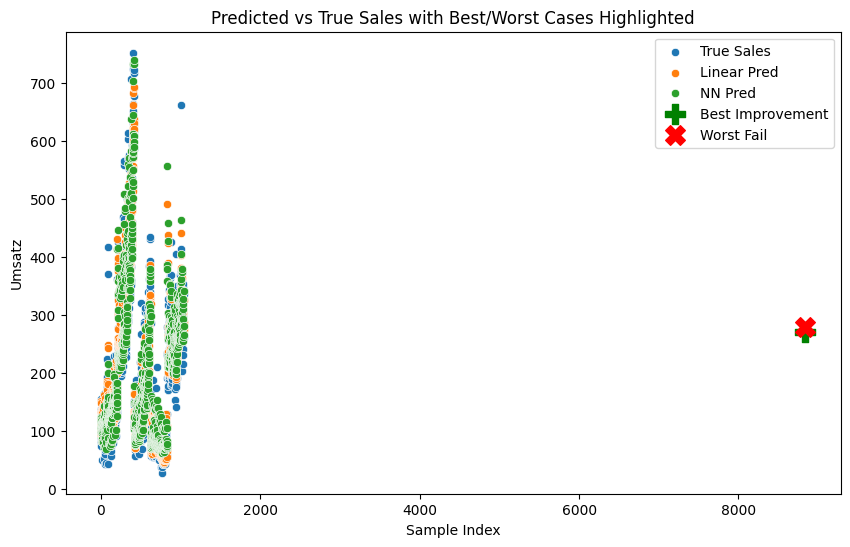

In [73]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=range(len(y_test)), y=y_test, label="True Sales")
sns.scatterplot(x=range(len(y_test)), y=y_pred_lin, label="Linear Pred")
sns.scatterplot(x=range(len(y_test)), y=y_pred_nn, label="NN Pred")

# Highlight best and worst
plt.scatter(best_idx, best_case["y_true"], color="green", s=200, marker="P", label="Best Improvement")
plt.scatter(worst_idx, worst_case["y_true"], color="red", s=200, marker="X", label="Worst Fail")

plt.xlabel("Sample Index")
plt.ylabel("Umsatz")
plt.title("Predicted vs True Sales with Best/Worst Cases Highlighted")
plt.legend()
plt.show()


In [48]:
# Recreate test dataframe
df_test_eval = X_test.copy()
df_test_eval['y_true'] = y_test.values
df_test_eval['y_pred_lin'] = y_pred_lin
df_test_eval['y_pred_nn'] = y_pred_nn

# Reconstruct Warengruppe from one-hot encoding
warengruppe_cols = [col for col in df_test_eval.columns if col.startswith("Warengruppe_")]

def reconstruct_warengruppe(row):
    for idx, col in enumerate(warengruppe_cols, start=2):  # start=2 because Warengruppe_1 was dropped
        if row[col] == 1:
            return idx
    return 1  # if all zeros, it's Warengruppe_1

df_test_eval['Warengruppe'] = df_test_eval.apply(reconstruct_warengruppe, axis=1)

# Compute improvement over linear model
df_test_eval['improvement'] = df_test_eval['y_pred_lin'] - df_test_eval['y_pred_nn']

df_test_eval.head()


,Temperatur,Bewoelkung,Windgeschwindigkeit,Wettercode,KielerWoche,is_weekend,dow_sin,dow_cos,doy_sin,doy_cos,...,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,y_true,y_pred_lin,y_pred_nn,Warengruppe,improvement
1611,5.7000,6.0,8.0,61.0,0,0,0.781831,0.623490,0.034422,0.999407,...,False,False,False,False,False,154.786375,132.667796,114.209846,1,18.457950
1612,6.4750,7.0,11.0,61.0,0,0,0.974928,-0.222521,0.051620,0.998667,...,False,False,False,False,False,80.171134,117.841261,105.635864,1,12.205397
1613,5.5125,6.0,7.0,61.0,0,0,0.433884,-0.900969,0.068802,0.997630,...,False,False,False,False,False,136.591619,110.813758,122.660263,1,-11.846505
1614,4.3250,8.0,10.0,61.0,0,0,-0.433884,-0.900969,0.085965,0.996298,...,False,False,False,False,False,91.934018,116.005510,122.341713,1,-6.336203
1615,3.1875,7.0,8.0,61.0,0,1,-0.974928,-0.222521,0.103102,0.994671,...,False,False,False,False,False,73.849524,150.473587,118.292198,1,32.181389


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\747284937.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


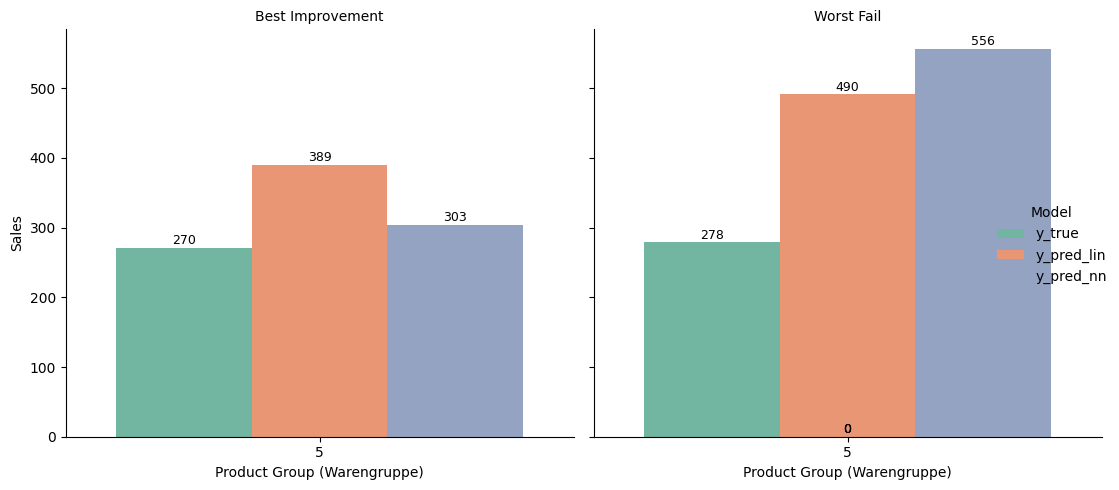

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mark cases
best_case['Case'] = 'Best Improvement'
worst_case['Case'] = 'Worst Fail'

highlight_cases = pd.concat([best_case, worst_case])

# Reconstruct numeric Warengruppe
def reconstruct_warengruppe(row):
    for i in range(2, 7):  # Warengruppe_2 to Warengruppe_6
        if f'Warengruppe_{i}' in row and row[f'Warengruppe_{i}'] == 1:
            return i
    return 1  # if none are 1, it's the dropped category

highlight_cases['Warengruppe_num'] = highlight_cases.apply(reconstruct_warengruppe, axis=1)

# Melt for plotting
plot_df = highlight_cases.melt(
    id_vars=['Warengruppe_num', 'Case'], 
    value_vars=['y_true', 'y_pred_lin', 'y_pred_nn'], 
    var_name='Model', 
    value_name='Sales'
)

# Set consistent order for models
model_order = ['y_true', 'y_pred_lin', 'y_pred_nn']

# Create facet plot
g = sns.catplot(
    x='Warengruppe_num',
    y='Sales',
    hue='Model',
    col='Case',
    data=plot_df,
    kind='bar',
    palette='Set2',
    ci=None,
    col_order=['Best Improvement', 'Worst Fail'],
    height=5,
    aspect=1
)

# Titles and labels
g.set_axis_labels("Product Group (Warengruppe)", "Sales")
g.set_titles("{col_name}")
g._legend.set_title("Model")

# Annotate bars with exact values
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2., 
            height + 1, 
            f'{int(height)}', 
            ha="center", 
            va='bottom', 
            fontsize=9
        )

plt.tight_layout()
plt.show()


In [65]:
df_eval = df_eval.copy()

df_eval["abs_err_lin"] = np.abs(df_eval["y_true"] - df_eval["y_pred_lin"])
df_eval["abs_err_nn"] = np.abs(df_eval["y_true"] - df_eval["y_pred_nn"])

df_eval["delta_improvement"] = df_eval["abs_err_lin"] - df_eval["abs_err_nn"]


In [66]:
best_improvement = df_eval.sort_values("delta_improvement", ascending=False).head(1)
worst_fail = df_eval.sort_values("abs_err_nn", ascending=False).head(1)


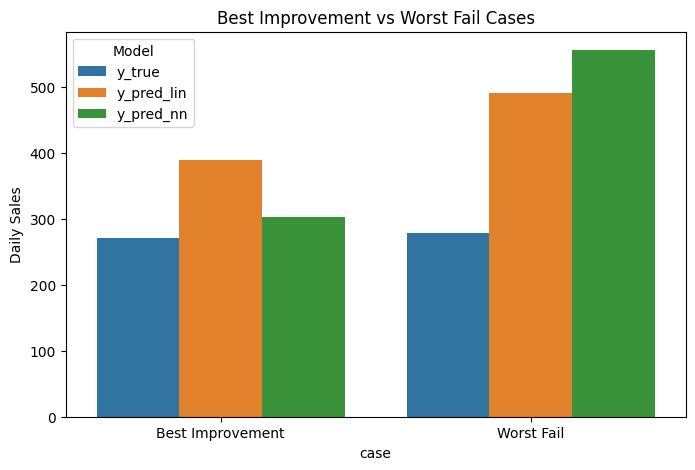

In [70]:
case_df = pd.concat([
    best_improvement.assign(case="Best Improvement"),
    worst_fail.assign(case="Worst Fail")
])

plt.figure(figsize=(8,5))
sns.barplot(
    data=case_df.melt(
        id_vars="case",
        value_vars=["y_true", "y_pred_lin", "y_pred_nn"],
        var_name="Model",
        value_name="Sales"
    ),
    x="case",
    y="Sales",
    hue="Model"
)
plt.title("Best Improvement vs Worst Fail Cases")
plt.ylabel("Daily Sales")
plt.show()


### Best Improvement Case

In the best improvement example, sales exhibit strong weekly regularity and
stable short-term momentum. Both `lag_7` and `rolling_7` features take values
consistent with the dominant patterns observed in the exploratory analysis.

The linear model underestimates this interaction, while the neural network
successfully combines routine-based and momentum-based signals, resulting in a
substantial reduction in prediction error.

### Worst Failure Case

The worst failure corresponds to a period where both weekly routine and recent
momentum signals break down. Sales deviate sharply from both the previous week’s
pattern and the short-term rolling average.

Such cases often coincide with irregular events or abrupt demand shifts that are
not explicitly encoded in the feature set. As a result, both linear and neural
models struggle, highlighting the limits of purely time-based feature
engineering.


Taken together, the weekly routine and momentum features explain why the neural
network achieves its largest gains in stable, pattern-consistent regimes, while
both models fail under irregular demand conditions.


### Interpreting Bar Charts with Confidence Intervals

Each bar represents the mean daily sales for a subset of observations defined
by a self-created variable. The vertical error bars indicate 95% confidence
intervals around the mean, providing an estimate of uncertainty due to sample
size and variability.

Non-overlapping confidence intervals suggest a robust difference between
groups, while overlapping intervals indicate higher uncertainty and weaker
evidence for separation.


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make a copy for plotting
df_plot = df.copy()

# Bin lag_7 into tertiles
df_plot["lag7_bin"] = pd.qcut(
    df_plot["lag_7"],
    q=3,
    labels=["Low lag_7", "Medium lag_7", "High lag_7"]
)

# Bin rolling_7 into tertiles
df_plot["roll7_bin"] = pd.qcut(
    df_plot["rolling_7"],
    q=3,
    labels=["Low rolling_7", "Medium rolling_7", "High rolling_7"]
)


In [55]:
def mean_ci(series):
    mean = series.mean()
    ci = 1.96 * series.std() / np.sqrt(len(series))
    return mean, ci


## Bar charts with confidence intervals for two self-created variables
### Weekly Routine Effect (Lag-7 Sales)

The weekly routine effect captures habitual purchasing behavior by using sales
from the same weekday in the previous week (`lag_7`) as a predictor.

Sales are grouped into low, medium, and high lag-7 bins, and the corresponding
average current-day sales are shown with confidence intervals. A monotonic
increase across bins indicates that customers tend to follow consistent weekly
buying patterns.

Differences across product groups suggest that some bakery items exhibit
stronger routine-driven demand than others.


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\3428994773.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("lag7_bin")["Umsatz"]


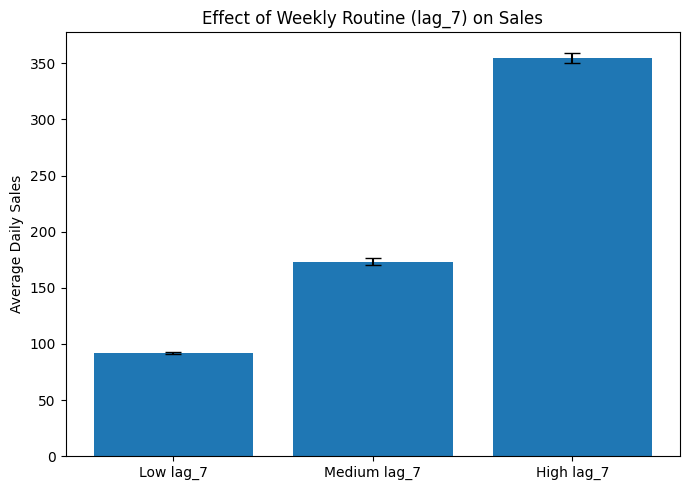

In [56]:
lag_stats = (
    df_plot
    .groupby("lag7_bin")["Umsatz"]
    .apply(mean_ci)
    .apply(pd.Series)
)

lag_stats.columns = ["mean", "ci"]

plt.figure(figsize=(7,5))
plt.bar(
    lag_stats.index,
    lag_stats["mean"],
    yerr=lag_stats["ci"],
    capsize=6
)
plt.ylabel("Average Daily Sales")
plt.title("Effect of Weekly Routine (lag_7) on Sales")
plt.tight_layout()
plt.show()


### Short-Term Momentum Effect (Rolling-7 Average)

The momentum effect is captured using a 7-day rolling average of sales
(`rolling_7`), representing recent demand trends rather than fixed weekly
patterns.

Higher rolling averages indicate sustained demand over the past week, while
lower values reflect declining or volatile sales. Clear separation between bins
suggests that short-term momentum plays an important role in explaining current
sales levels.

Variation across product groups highlights differences in how quickly demand
responds to recent sales trends.


C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\949080095.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("roll7_bin")["Umsatz"]


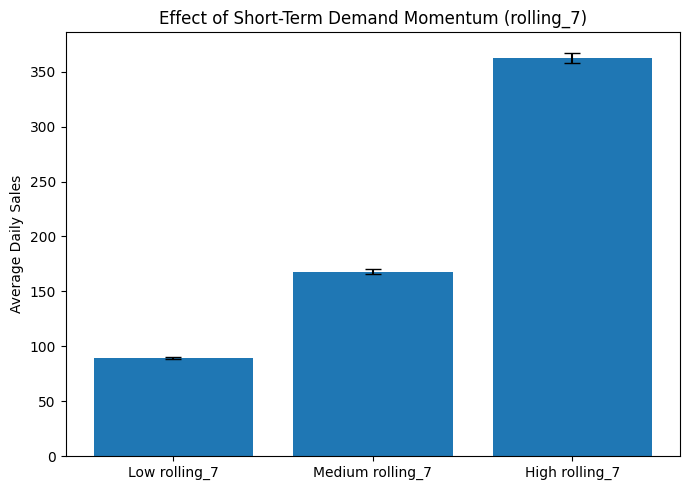

In [57]:
roll_stats = (
    df_plot
    .groupby("roll7_bin")["Umsatz"]
    .apply(mean_ci)
    .apply(pd.Series)
)

roll_stats.columns = ["mean", "ci"]

plt.figure(figsize=(7,5))
plt.bar(
    roll_stats.index,
    roll_stats["mean"],
    yerr=roll_stats["ci"],
    capsize=6
)
plt.ylabel("Average Daily Sales")
plt.title("Effect of Short-Term Demand Momentum (rolling_7)")
plt.tight_layout()
plt.show()


In [62]:
df_plot = df.copy()

warengruppe_cols = [c for c in df_plot.columns if c.startswith("Warengruppe_")]

def recover_warengruppe(row):
    for col in warengruppe_cols:
        if row[col] == 1:
            return col.replace("Warengruppe_", "")
    return "1"  # reference group (dropped category)

df_plot["Warengruppe"] = df_plot.apply(recover_warengruppe, axis=1)
df_plot["Warengruppe"] = df_plot["Warengruppe"].astype(str)


### Weekly Routine Effect (lag_7) of different product groups

C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\3588906790.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("lag7_bin")["Umsatz"]


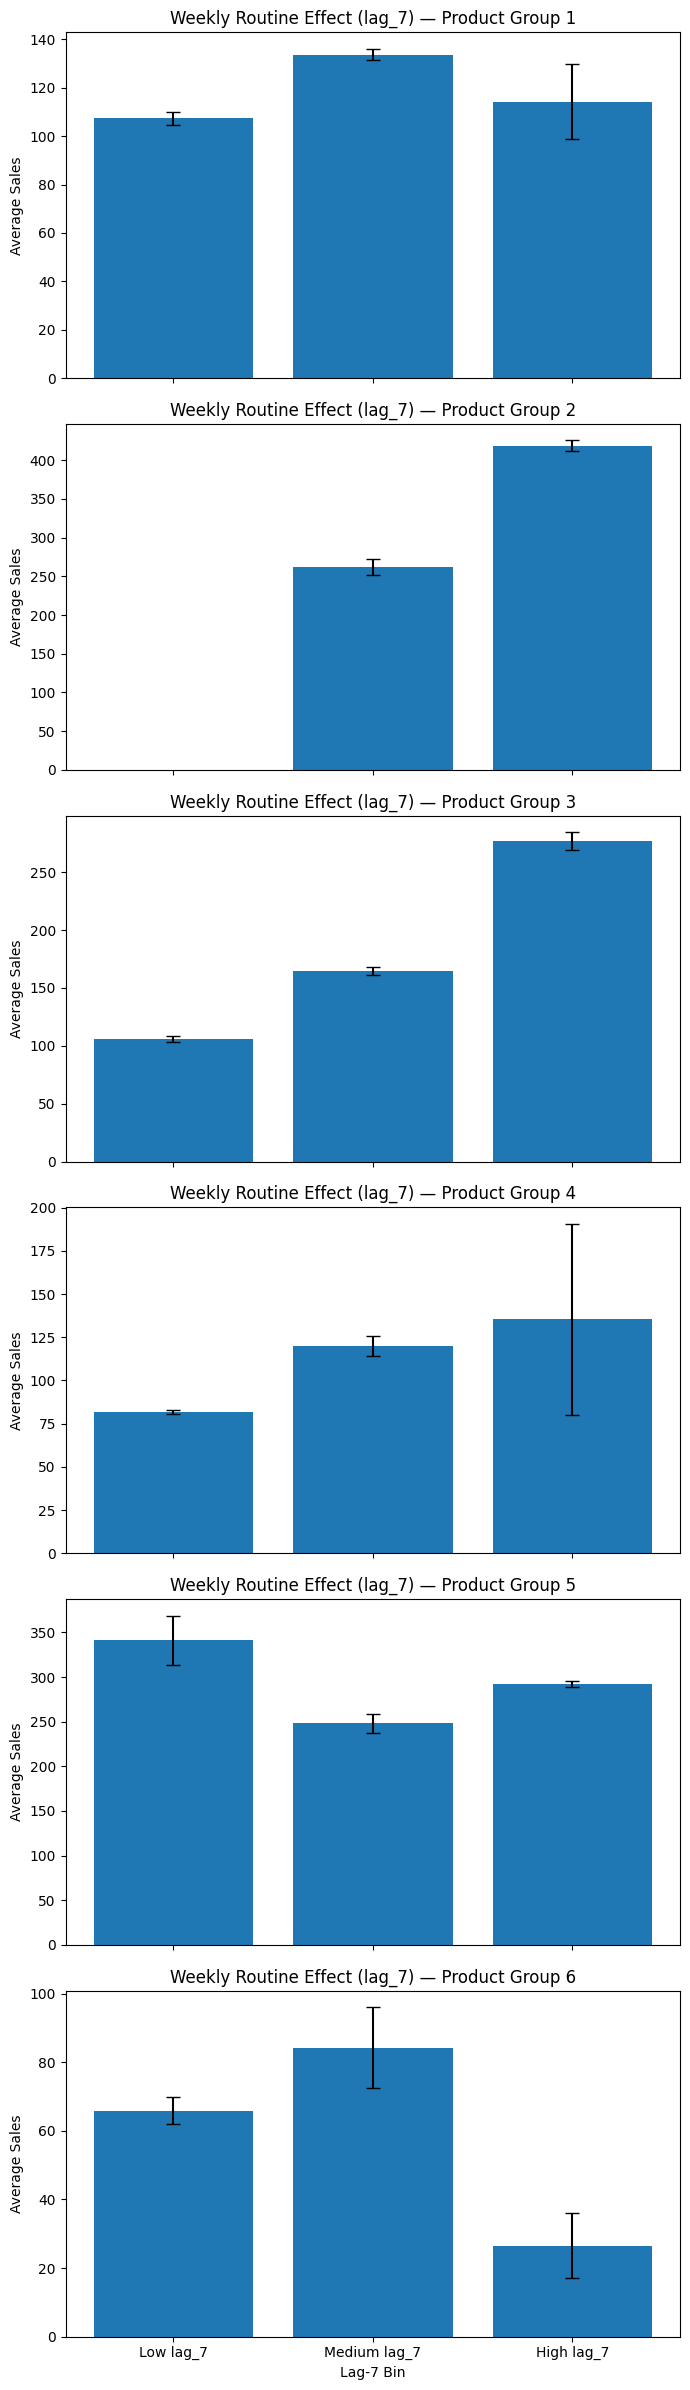

In [63]:
df_plot["lag7_bin"] = pd.qcut(
    df_plot["lag_7"], q=3,
    labels=["Low lag_7", "Medium lag_7", "High lag_7"]
)

import numpy as np

def mean_ci(x):
    mean = x.mean()
    ci = 1.96 * x.std() / np.sqrt(len(x))
    return mean, ci

groups = sorted(df_plot["Warengruppe"].unique())
fig, axes = plt.subplots(len(groups), 1, figsize=(7, 4 * len(groups)), sharex=True)

if len(groups) == 1:
    axes = [axes]

for ax, grp in zip(axes, groups):
    tmp = df_plot[df_plot["Warengruppe"] == grp]

    stats = (
        tmp.groupby("lag7_bin")["Umsatz"]
        .apply(mean_ci)
        .apply(pd.Series)
    )
    stats.columns = ["mean", "ci"]

    ax.bar(stats.index, stats["mean"], yerr=stats["ci"], capsize=5)
    ax.set_title(f"Weekly Routine Effect (lag_7) — Product Group {grp}")
    ax.set_ylabel("Average Sales")

plt.xlabel("Lag-7 Bin")
plt.tight_layout()
plt.show()


### Momentum effect (rolling_7) of different product groups

C:\Users\Vaishali\AppData\Local\Temp\ipykernel_23172\1224163521.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("roll7_bin")["Umsatz"]


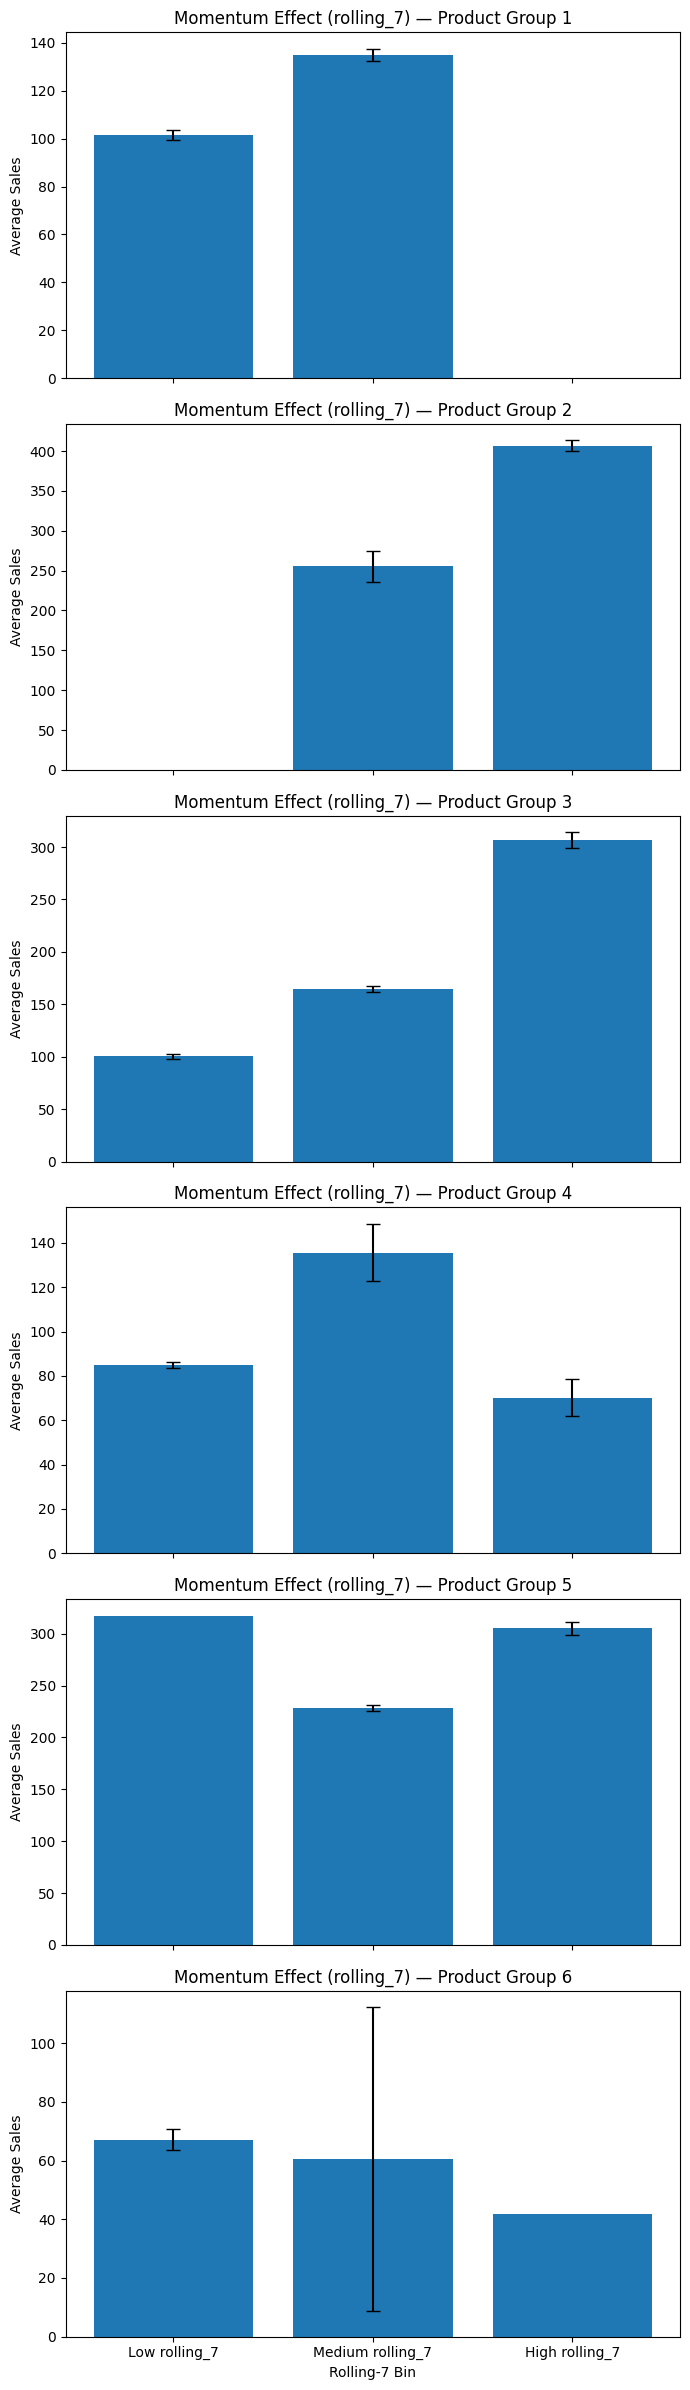

In [64]:
df_plot["roll7_bin"] = pd.qcut(
    df_plot["rolling_7"], q=3,
    labels=["Low rolling_7", "Medium rolling_7", "High rolling_7"]
)

fig, axes = plt.subplots(len(groups), 1, figsize=(7, 4 * len(groups)), sharex=True)

if len(groups) == 1:
    axes = [axes]

for ax, grp in zip(axes, groups):
    tmp = df_plot[df_plot["Warengruppe"] == grp]

    stats = (
        tmp.groupby("roll7_bin")["Umsatz"]
        .apply(mean_ci)
        .apply(pd.Series)
    )
    stats.columns = ["mean", "ci"]

    ax.bar(stats.index, stats["mean"], yerr=stats["ci"], capsize=5)
    ax.set_title(f"Momentum Effect (rolling_7) — Product Group {grp}")
    ax.set_ylabel("Average Sales")

plt.xlabel("Rolling-7 Bin")
plt.tight_layout()
plt.show()
